In [1]:
import numpy as np
import pandas as pd
import spacy
import json
import re
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import PorterStemmer
from string import punctuation
from sklearn.manifold import TSNE
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)

In [3]:
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [4]:
df.shape

(200853, 6)

In [5]:
df.drop(['authors','link','short_description','date'],inplace = True,axis = 1)

In [6]:
df.head(2)

,category,headline
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...


### EDA

In [7]:
df['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

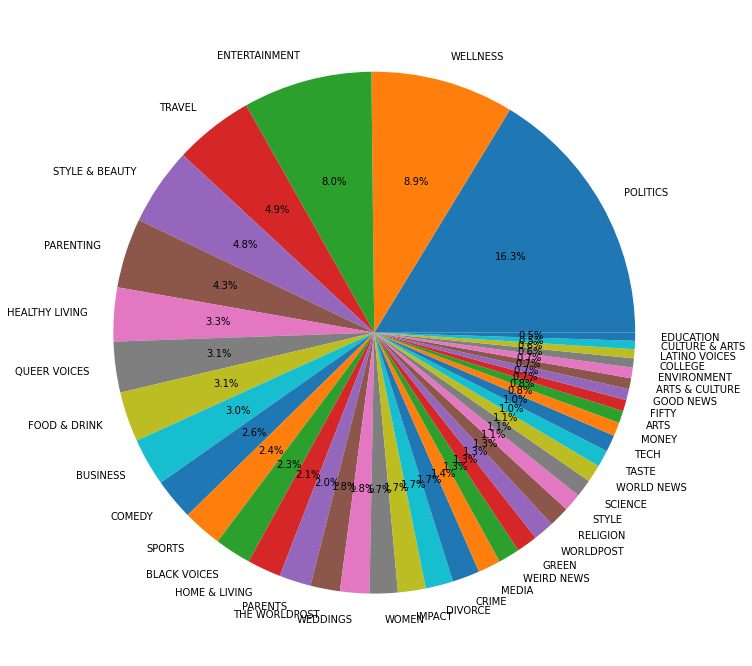

In [8]:
fig = plt.figure(figsize=(12,12))
plt.pie(df['category'].value_counts().values, 
        labels=df['category'].value_counts().index,
        autopct='%1.1f%%');

In [9]:
df['headline_len'] = df['headline'].apply(lambda x: len(str(x).split())) 

In [10]:
df['headline_len'].describe()

count    200853.000000
mean          9.538563
std           3.089320
min           0.000000
25%           7.000000
50%          10.000000
75%          12.000000
max          44.000000
Name: headline_len, dtype: float64

C:\Users\Suraj\anaconda3\envs\tensorflowenv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


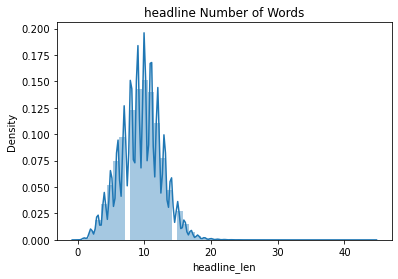

In [11]:
sns.distplot(df['headline_len'])
plt.title('headline Number of Words')
plt.show()

In [12]:
df.isnull().sum()

category        0
headline        0
headline_len    0
dtype: int64

### Data Cleaning and processing

In [13]:
df.duplicated().sum()

1398

In [14]:
df.drop_duplicates(keep='last', inplace=True)

In [15]:
df.duplicated().sum()

0

In [16]:
df.shape

(199455, 3)

In [17]:
print(len(df[df['headline'] == ""]))

6


In [18]:
df.loc[df['headline'] == "", 'headline'] = np.nan
df.dropna(subset=['headline'], inplace=True)
print(len(df[df['headline'] == ""]))

0


In [19]:
df.shape

(199449, 3)

In [20]:
#Cleaning


SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}


def clean(text, stem_words=True):

    
    if pd.isnull(text):
        return ''

    if type(text) != str or text=='':
        return ''
    ps = PorterStemmer()
    
    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
       # Return a list of words
    text = ' '.join([word for word in text.split(" ") if word not in stop_words]).lower()
    #text = ' '.join([ps.stem(word) for word in text])
    return text

In [21]:
df['headline'] = df['headline'].apply(clean)

In [22]:
df.head()

,category,headline,headline_len
0,CRIME,there were 2 mass shootings in texas last week...,14
1,ENTERTAINMENT,will smith joins diplo and nicky jam for the 2...,14
2,ENTERTAINMENT,hugh grant marries for the first time at age 57,10
3,ENTERTAINMENT,jim carrey blasts 'castrato' adam schiff and d...,11
4,ENTERTAINMENT,julianna margulies uses donald trump poop bags...,13


### Group similar news categories

In [23]:
df['category'].value_counts().index

Index(['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY',
       'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK',
       'BUSINESS', 'COMEDY', 'SPORTS', 'BLACK VOICES', 'HOME & LIVING',
       'PARENTS', 'THE WORLDPOST', 'WEDDINGS', 'IMPACT', 'DIVORCE', 'CRIME',
       'WOMEN', 'MEDIA', 'WEIRD NEWS', 'GREEN', 'WORLDPOST', 'RELIGION',
       'STYLE', 'SCIENCE', 'WORLD NEWS', 'TASTE', 'TECH', 'MONEY', 'ARTS',
       'FIFTY', 'GOOD NEWS', 'ARTS & CULTURE', 'ENVIRONMENT', 'COLLEGE',
       'LATINO VOICES', 'CULTURE & ARTS', 'EDUCATION'],
      dtype='object')

In [24]:
categories = df['category'].value_counts().index

In [25]:
def groupnewscat(listofcat,newname):
    for cat in categories:
        if cat in listofcat:
            df.loc[df['category'] == cat,'category'] = newname

In [26]:
groupnewscat(listofcat = ['WELLNESS', 'HEALTHY LIVING','HOME & LIVING','STYLE & BEAUTY' ,'STYLE'],newname = 'LIFESTYLE AND WELLNESS')
groupnewscat(listofcat = ['SPORTS','ENTERTAINMENT' , 'COMEDY','WEIRD NEWS','ARTS'],newname = 'SPORTS AND ENTERTAINMENT')
groupnewscat(listofcat = ['TRAVEL', 'ARTS & CULTURE','CULTURE & ARTS','FOOD & DRINK', 'TASTE'],newname = 'TRAVEL-TOURISM AND ART-CULTURE')

In [27]:
df['category'].value_counts()

LIFESTYLE AND WELLNESS            39962
POLITICS                          32615
SPORTS AND ENTERTAINMENT          30216
TRAVEL-TOURISM AND ART-CULTURE    20526
PARENTING                          8626
QUEER VOICES                       6304
BUSINESS                           5924
BLACK VOICES                       4519
PARENTS                            3890
THE WORLDPOST                      3662
WEDDINGS                           3592
IMPACT                             3455
DIVORCE                            3420
CRIME                              3400
WOMEN                              3375
MEDIA                              2812
GREEN                              2617
WORLDPOST                          2578
RELIGION                           2547
SCIENCE                            2176
WORLD NEWS                         2174
TECH                               2027
MONEY                              1705
FIFTY                              1401
GOOD NEWS                          1398


In [28]:
df = df[df['category'].isin(['LIFESTYLE AND WELLNESS','POLITICS','SPORTS AND ENTERTAINMENT','TRAVEL-TOURISM AND ART-CULTURE'])].copy()

In [29]:
df.drop('headline_len',axis = 1,inplace = True)

In [30]:
df['category'].value_counts()

LIFESTYLE AND WELLNESS            39962
POLITICS                          32615
SPORTS AND ENTERTAINMENT          30216
TRAVEL-TOURISM AND ART-CULTURE    20526
Name: category, dtype: int64

In [31]:
df.shape

(123319, 2)

In [32]:
df

,category,headline
1,SPORTS AND ENTERTAINMENT,will smith joins diplo and nicky jam for the 2...
2,SPORTS AND ENTERTAINMENT,hugh grant marries for the first time at age 57
3,SPORTS AND ENTERTAINMENT,jim carrey blasts 'castrato' adam schiff and d...
4,SPORTS AND ENTERTAINMENT,julianna margulies uses donald trump poop bags...
5,SPORTS AND ENTERTAINMENT,morgan freeman 'devastated' that sexual harass...
...,...,...
200842,TRAVEL-TOURISM AND ART-CULTURE,allard van hoorn 'urban songline' explores re...
200849,SPORTS AND ENTERTAINMENT,maria sharapova stunned by victoria azarenka i...
200850,SPORTS AND ENTERTAINMENT,"giants over patriots, jets over colts among m..."
200851,SPORTS AND ENTERTAINMENT,aldon smith arrested: 49ers linebacker busted ...


In [33]:
df = shuffle(df)
df.reset_index(inplace=True, drop=True) 

In [34]:
df

,category,headline
0,LIFESTYLE AND WELLNESS,special delivery
1,TRAVEL-TOURISM AND ART-CULTURE,how deal with lost restaurant reservation
2,SPORTS AND ENTERTAINMENT,nfl champs open season with anthem fail
3,TRAVEL-TOURISM AND ART-CULTURE,how decode wine label
4,POLITICS,"daniel donovan, prosecutor who failed to indic..."
...,...,...
123314,SPORTS AND ENTERTAINMENT,kellyanne conway has some thoughts on sean spi...
123315,LIFESTYLE AND WELLNESS,6 things your dreams can tell you about your h...
123316,POLITICS,hillary clinton problem is that she not pro...
123317,SPORTS AND ENTERTAINMENT,taste sacred fools la


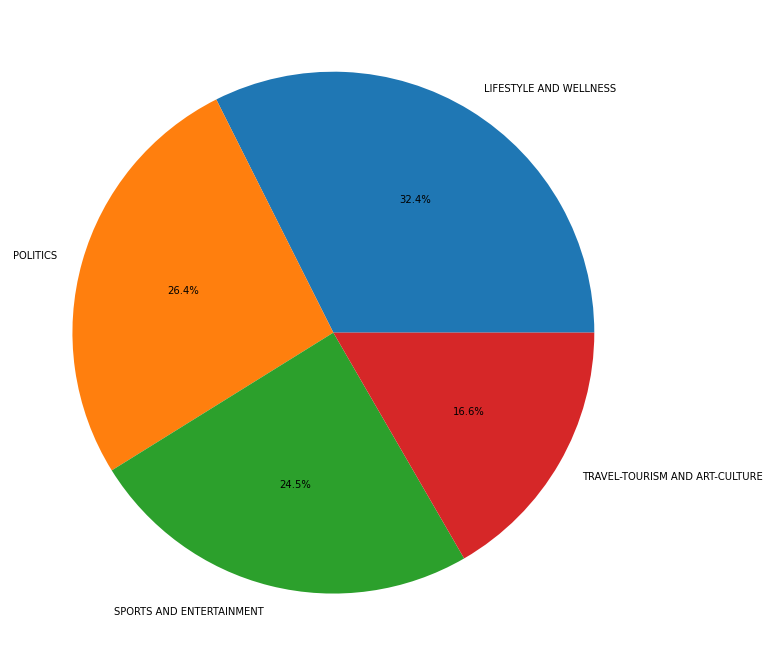

In [35]:
fig = plt.figure(figsize=(12,12))
plt.pie(df['category'].value_counts().values, 
        labels=df['category'].value_counts().index,
        autopct='%1.1f%%');

In [2]:
import gensim
import smart_open
from gensim.models import Word2Vec

In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format('C:\\Users\\Suraj\\GoogleNews-vectors-negative300.bin.gz', binary=True)

In [4]:
def sent2vec(s):
    words = str(s).lower() #lower the sentence
    words = word_tokenize(words) #tokenize the sentence
    words = [w for w in words if not w in stop_words] #Filter out the stop words
    words = [w for w in words if w.isalpha()] #Filter out non-alpha characters
    M = []
    for w in words:#loop through each word in the sentence
        try:
            M.append(model[w])#Gensim model converts each word in the sentence to a 300-dim vector space and appends to a list.
        except:
            continue
    M = np.array(M) #convert the list to array. Shape = (num_of_words_in_sentence,300)
    v = M.sum(axis=0) #Sum up along the num_of_words_in_sentence through 300-dim. Shape = (1,300) 
    return v / np.sqrt((v ** 2).sum()) #normalize the values with the sum

In [39]:
from tqdm import tqdm_notebook 
headline_vector = np.zeros((df.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 1
for i, q in enumerate(tqdm_notebook(df.headline.values)):
    headline_vector[i, :] = sent2vec(q)

C:\Users\Suraj\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\Suraj\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


In [40]:
tempX = pd.DataFrame(headline_vector)

In [41]:
tempX

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.039386,0.042379,-0.031393,0.078908,-0.074386,-0.016122,0.009659,-0.056324,0.045236,-0.008571,...,0.038638,-0.134416,-0.018843,0.070065,0.085830,0.078636,-0.102172,0.010408,-0.030135,-0.037753
1,0.025818,-0.013682,0.021837,0.058051,-0.046843,0.054496,-0.046572,-0.054418,0.106518,0.043442,...,0.031383,0.027876,-0.028142,0.109068,0.058283,0.013682,-0.043249,-0.099561,0.036794,-0.054573
2,0.010420,0.038533,0.083061,0.083553,-0.023260,-0.108668,0.022049,-0.021601,0.093530,0.180234,...,0.088148,-0.041285,-0.060477,-0.123584,0.038293,0.013700,-0.033777,-0.113730,-0.004414,-0.054014
3,-0.001583,-0.048330,-0.059423,0.116162,-0.040500,0.123576,-0.033597,-0.068894,0.050010,0.003862,...,0.059626,0.005175,-0.017069,0.054026,0.008612,-0.126125,0.047114,-0.031705,0.052752,0.041900
4,0.012898,0.031927,0.029007,0.021951,-0.028630,-0.088917,-0.007211,0.001620,0.109752,0.044028,...,0.038723,0.003075,-0.046203,0.075983,-0.066244,-0.052001,0.032396,-0.151554,-0.021241,0.079173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123314,-0.043709,0.069829,-0.028236,0.093184,-0.059866,0.003687,-0.044574,-0.103206,0.109173,0.016676,...,0.044782,-0.024557,0.051536,-0.014036,0.037827,-0.142692,0.014051,-0.091709,-0.045092,0.003989
123315,-0.026650,0.054856,0.037534,0.055790,-0.007197,-0.012489,0.116676,-0.012323,0.030891,0.000141,...,-0.008540,0.025719,-0.065925,-0.113097,-0.071780,-0.022468,0.065633,-0.035754,0.089151,-0.030234
123316,0.051752,0.066187,0.006141,0.125868,-0.159261,-0.022141,-0.003015,0.022496,0.005333,0.009158,...,-0.027045,-0.017032,0.001173,-0.053121,-0.112075,-0.038612,-0.035320,-0.008348,0.014798,0.019210
123317,0.079187,0.051702,0.065859,0.123627,-0.071062,0.061689,0.065823,-0.058909,0.012152,0.061511,...,0.016251,-0.015396,-0.046187,0.024733,-0.042017,-0.030256,-0.003564,-0.111190,-0.021062,0.085531


In [42]:
newdf = pd.concat([tempX,df],axis = 1)

In [43]:
newdf.isnull().sum()

0           149
1           149
2           149
3           149
4           149
           ... 
297         149
298         149
299         149
category      0
headline      0
Length: 302, dtype: int64

In [104]:
newdf.dropna(axis = 0,inplace = True)

In [44]:
newdf['category_encoded'] = LabelEncoder().fit_transform(newdf['category'])

In [45]:
newdf.head(2)

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,category,headline,category_encoded
0,-0.039386,0.042379,-0.031393,0.078908,-0.074386,-0.016122,0.009659,-0.056324,0.045236,-0.008571,...,0.070065,0.085830,0.078636,-0.102172,0.010408,-0.030135,-0.037753,LIFESTYLE AND WELLNESS,special delivery,0
1,0.025818,-0.013682,0.021837,0.058051,-0.046843,0.054496,-0.046572,-0.054418,0.106518,0.043442,...,0.109068,0.058283,0.013682,-0.043249,-0.099561,0.036794,-0.054573,TRAVEL-TOURISM AND ART-CULTURE,how deal with lost restaurant reservation,3


In [46]:
newdf.shape

(123319, 303)

In [ ]:
newdf.to_csv('finale_features.csv')

In [5]:
newdf = pd.read_csv('finale_features.csv')

In [25]:
newdf['headline'][:1]

0    special delivery
Name: headline, dtype: object

In [7]:
newdf.drop('Unnamed: 0',axis = 1,inplace = True)

In [8]:
newdf.head()

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,category,headline,category_encoded
0,-0.039386,0.042379,-0.031393,0.078908,-0.074386,-0.016122,0.009659,-0.056324,0.045236,-0.008571,...,0.070065,0.085830,0.078636,-0.102172,0.010408,-0.030135,-0.037753,LIFESTYLE AND WELLNESS,special delivery,0
1,0.025818,-0.013682,0.021837,0.058051,-0.046843,0.054496,-0.046572,-0.054418,0.106518,0.043442,...,0.109068,0.058283,0.013682,-0.043249,-0.099561,0.036794,-0.054573,TRAVEL-TOURISM AND ART-CULTURE,how deal with lost restaurant reservation,3
2,0.010420,0.038533,0.083061,0.083553,-0.023260,-0.108668,0.022049,-0.021601,0.093530,0.180234,...,-0.123584,0.038293,0.013700,-0.033777,-0.113730,-0.004414,-0.054014,SPORTS AND ENTERTAINMENT,nfl champs open season with anthem fail,2
3,-0.001583,-0.048330,-0.059423,0.116162,-0.040500,0.123576,-0.033597,-0.068894,0.050010,0.003862,...,0.054026,0.008612,-0.126125,0.047114,-0.031705,0.052752,0.041900,TRAVEL-TOURISM AND ART-CULTURE,how decode wine label,3
4,0.012898,0.031927,0.029007,0.021951,-0.028630,-0.088917,-0.007211,0.001620,0.109752,0.044028,...,0.075983,-0.066244,-0.052001,0.032396,-0.151554,-0.021241,0.079173,POLITICS,"daniel donovan, prosecutor who failed to indic...",1


In [9]:
newdf.isnull().sum()

0                   0
1                   0
2                   0
3                   0
4                   0
                   ..
298                 0
299                 0
category            0
headline            0
category_encoded    0
Length: 303, dtype: int64

In [10]:
newdf.shape

(123170, 303)

In [11]:
X = newdf.iloc[:,0:300]

In [12]:
X.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
295    0
296    0
297    0
298    0
299    0
Length: 300, dtype: int64

In [13]:
y = newdf['category_encoded']

### Model Training

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.1,shuffle = True)

In [15]:
X_train.shape

(110853, 300)

In [16]:
X_test.shape

(12317, 300)

In [17]:
y_train.shape

(110853,)

In [18]:
y_test.shape

(12317,)

In [19]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Gaussian Naive Bayes Classifier

0.7035082496639694
0.696760574815296
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      3990
           1       0.85      0.79      0.82      3260
           2       0.58      0.66      0.62      3018
           3       0.67      0.63      0.65      2049

    accuracy                           0.70     12317
   macro avg       0.70      0.69      0.69     12317
weighted avg       0.70      0.70      0.70     12317



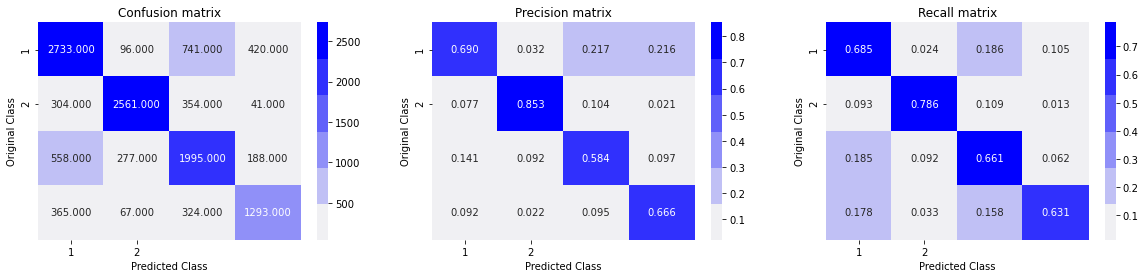

In [117]:
gnbclf = GaussianNB()
gnbclf.fit(X_train,y_train)
y_predtrain = gnbclf.predict(X_train)
y_pred = gnbclf.predict(X_test)
print(accuracy_score(y_train, y_predtrain))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

In [118]:
import pickle
import joblib
file = open('GNB.pkl', 'wb') #save model in the pickle file
pickle.dump(gnbclf,file) 

### K-Nearest Neighbors Classifier

For values of n =  3 The accuracy is: 79.07769749127223
For values of n =  5 The accuracy is: 80.08443614516521
For values of n =  9 The accuracy is: 80.5634488917756
For values of n =  11 The accuracy is: 80.93691645692944
For values of n =  17 The accuracy is: 81.16424454006658


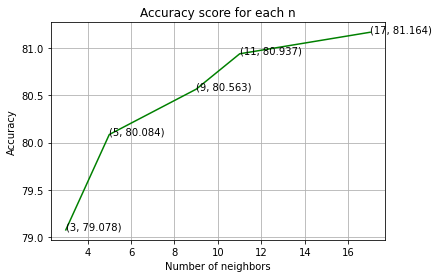

In [29]:
n_list = [3,5,9,11,17]
acc_score = []
for i in n_list:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)  
    y_pred = knn.predict(X_test)
    print('For values of n = ', i, "The accuracy is:",accuracy_score(y_test, y_pred)*100)
    acc_score.append(accuracy_score(y_test, y_pred)*100)

fig, ax = plt.subplots()
ax.plot(n_list,acc_score,c='g')
for i, txt in enumerate(np.round(acc_score,3)):
    ax.annotate((n_list[i],np.round(txt,3)), (n_list[i],acc_score[i]))
plt.grid()
plt.title("Accuracy score for each n")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.show()

0.8276726836441053
0.8116424454006658
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      3990
           1       0.84      0.89      0.86      3260
           2       0.80      0.71      0.75      3018
           3       0.83      0.73      0.78      2049

    accuracy                           0.81     12317
   macro avg       0.81      0.80      0.80     12317
weighted avg       0.81      0.81      0.81     12317



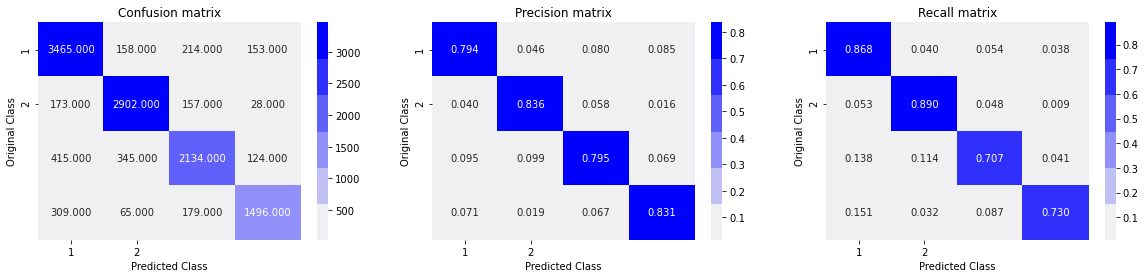

In [30]:
knn = KNeighborsClassifier(n_neighbors = 17)
knn.fit(X_train,y_train)
y_predtrain = knn.predict(X_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_train, y_predtrain))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

In [32]:
import pickle
import joblib
file = open('KNN.pkl', 'wb') #save model in the pickle file
pickle.dump(knn,file)

### Random Forest Classifier

0.9989265062740746
0.751806446374929
              precision    recall  f1-score   support

           0       0.71      0.86      0.78      3990
           1       0.82      0.83      0.83      3260
           2       0.70      0.67      0.69      3018
           3       0.85      0.53      0.65      2049

    accuracy                           0.75     12317
   macro avg       0.77      0.72      0.74     12317
weighted avg       0.76      0.75      0.75     12317



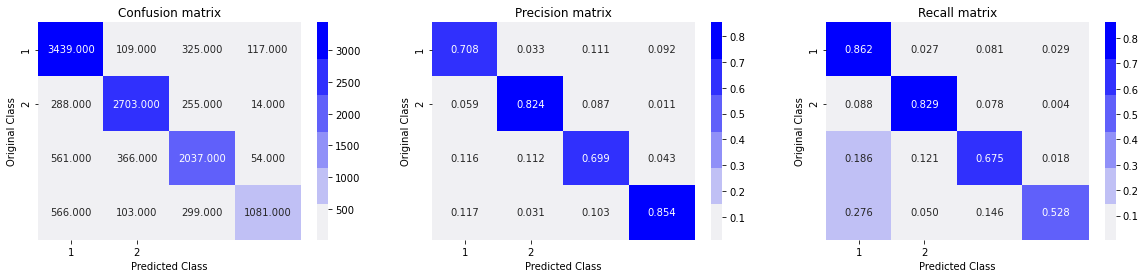

In [22]:
# Number of trees in random forest
#n_estimators = [200,400,600,800,1000]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(5, 20, num = 4)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]

#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf
#               }

#acc_score = []
#for i in n_estimators:
#    rf = RandomForestClassifier(n_estimators = i)
#    rf.fit(X_train,y_train)  
#    y_pred = rf.predict(X_test)
#    print('For values of n = ', i, "The accuracy is:",accuracy_score(y_test, y_pred)*100)
#    acc_score.append(accuracy_score(y_test, y_pred)*100)

#fig, ax = plt.subplots()
#ax.plot(n_estimators,acc_score,c='g')
#for i, txt in enumerate(np.round(acc_score,3)):
#   ax.annotate((n_estimators[i],np.round(txt,3)), (n_estimators[i],acc_score[i]))
#plt.grid()
#plt.title("Accuracy score for each n_estimator")
#plt.xlabel("Number of estimators")
#plt.ylabel("Accuracy")
#plt.show()
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_predtrain = rf.predict(X_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_train, y_predtrain))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

In [23]:
import pickle
import joblib
file = open('RFC.pkl', 'wb') #save model in the pickle file
pickle.dump(rf,file)

### XGBoost Classifier

0.7593299234120863
0.7476658277177884
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      3990
           1       0.82      0.83      0.82      3260
           2       0.67      0.68      0.68      3018
           3       0.78      0.60      0.68      2049

    accuracy                           0.75     12317
   macro avg       0.75      0.73      0.74     12317
weighted avg       0.75      0.75      0.75     12317



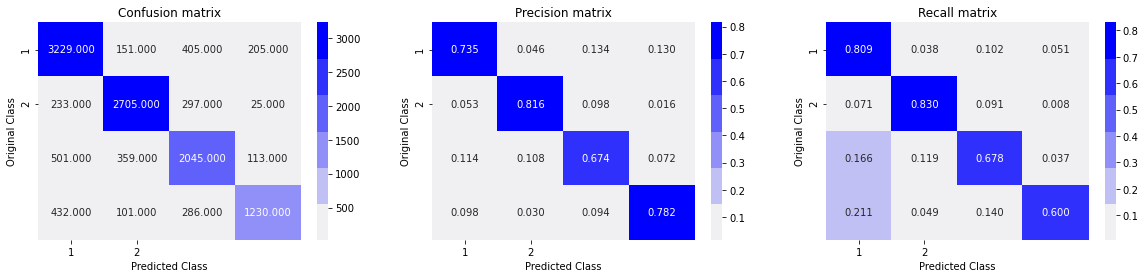

In [39]:
import xgboost as xgb
xgclf=xgb.XGBClassifier()
xgclf.fit(X_train,y_train)
y_predtrain = xgclf.predict(X_train)
y_pred = xgclf.predict(X_test)
print(accuracy_score(y_train, y_predtrain))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

In [46]:
import cloudpickle as cp
import pickle
import joblib
file = open('XGB.pkl', 'wb') #save model in the pickle file
cp.dump(xgclf,file)

In [26]:
headline = 'special delivery'
a = {'headline': headline}
testdf = pd.DataFrame(a,columns = ['headline'],index=[0])
testdf

,headline
0,special delivery


In [27]:
headline_vector = np.zeros((testdf.shape[0], 300))
for i, q in enumerate(testdf.headline.values):
    headline_vector[i, :] = sent2vec(q)

In [28]:
xhead = pd.DataFrame(headline_vector)


        0         1         2         3         4         5         6    \
0 -0.039386  0.042379 -0.031393  0.078908 -0.074386 -0.016122  0.009659   

        7         8         9    ...       290       291       292       293  \
0 -0.056324  0.045236 -0.008571  ...  0.038638 -0.134416 -0.018843  0.070065   

       294       295       296       297       298       299  
0  0.08583  0.078636 -0.102172  0.010408 -0.030135 -0.037753  

[1 rows x 300 columns]


In [29]:
xhead

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.039386,0.042379,-0.031393,0.078908,-0.074386,-0.016122,0.009659,-0.056324,0.045236,-0.008571,...,0.038638,-0.134416,-0.018843,0.070065,0.08583,0.078636,-0.102172,0.010408,-0.030135,-0.037753


In [33]:
pickle_model=pickle.load(open('RFC.pkl','rb'))

In [34]:
ypred = pickle_model.predict(xhead)

In [35]:
ypred

array([0], dtype=int64)

In [49]:
pickle_model=pickle.load(open('GNB.pkl','rb'))

In [50]:
ypred = pickle_model.predict(xhead)

In [51]:
ypred

array([0])